In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Datasets
from torch.utils.data import DataLoader 
from torch.optim import SGD, Adam
import numpy as np
import  matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pathlib import Path


device = torch.device('cuda'  if torch.cuda.is_available()  else 'cpu')

In [3]:

trainset = Datasets.CIFAR10(root='./data', train=True,
										download=True)
train_imgs = trainset.data
train_labels = trainset.targets

In [4]:
testset = Datasets.CIFAR10(root='./data', train=False,
									   download=True)

validaction_imgs = testset.data
validation_labels = testset.targets

train_imgs shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


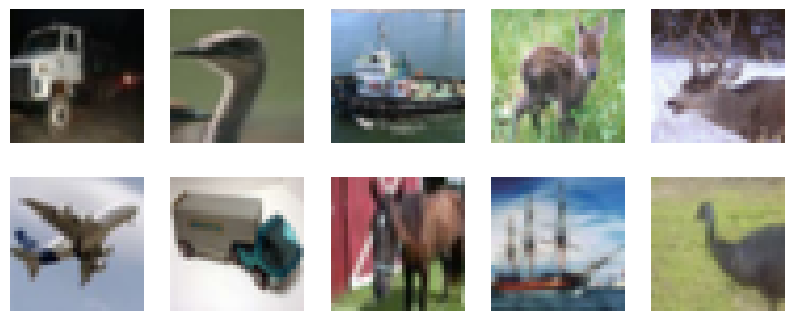

In [5]:
num_classes = 10
label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



print('train_imgs shape:', train_imgs.shape)
print(train_imgs.shape[0], 'train samples')
print(validaction_imgs.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(train_imgs)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(train_imgs[i:i+1][0])
        
# Normalize
x_train = train_imgs.astype('float32')
x_test = validaction_imgs.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
class CFAR_ten_Dataset(Dataset):
	
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __getitem__(self, ix):
		
		x, y = self.x[ix], self.y[ix]
		return torch.tensor(x/255).permute(2,0,1).to(device).float(), torch.tensor(y).float().to(device)
			
	def __len__(self):
		return len(self.x)

In [ ]:
def get_model():
	
	class Base_Cifar10CnnModel(nn.Module):
		def __init__(self):
			super().__init__()
			self.network = nn.Sequential(
			nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2,2), 
			
			nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2,2), 
			
			nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2,2), 
			
			nn.Flatten(),
			nn.Linear(256*4*4,1024),
			nn.ReLU(),
			nn.Linear(1024,512),
			nn.ReLU(),
			nn.Linear(512,10))
			
		def forward (self,x):
			return self.network(x)


	model = Base_Cifar10CnnModel().to(device)
	loss_fn = nn.CrossEntropyLoss()
	optimizer = Adam(model.parameters(), lr=1e-3)

	
	return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, optimizer, loss_fn):
	
	model.train()
	prediction = model(x)
	batch_loss = loss_fn(prediction, y.type(torch.int64))
	optimizer.zero_grad()
	batch_loss.backward()
	optimizer.step()
	
	
		
	return batch_loss.item()

In [ ]:
def get_data(batch_size = 500):
	train = CFAR_ten_Dataset(train_imgs, train_labels )
	trn_dl = DataLoader(train, batch_size=batch_size, shuffle=True)

	val = CFAR_ten_Dataset(validation_imgs, validation_labels)
	val_dl = DataLoader(val, batch_size=batch_size, shuffle=False)

	return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model,loss_fn ):
	prediction = model(x)
	val_loss = loss_fn(prediction, y.type(torch.int64))
	
	return val_loss.item()

In [ ]:
def accuracy(x, y, model):

	model.eval()
	prediction = model(x)
	max_values, argmaxes = prediction.max(-1)
	is_correct = argmaxes == y

	return is_correct.cpu().numpy().tolist()

In [15]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:

num_epochs = 30
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):


	train_epoch_losses, train_epoch_accuracies = [], []
	val_epoch_losses,val_epoch_accuracies = [], []


	# train loss
	for ix, (imgs, labels) in enumerate(trn_dl):
		batch_loss = train_batch(imgs, labels, model, optimizer, loss_fn)
		train_epoch_losses.append(batch_loss)
	train_epoch_loss = np.array(train_epoch_losses).mean()


	# validation loss
	for ix, (imgs, labels) in enumerate(val_dl):
		val_batch_loss = val_loss(imgs, labels, model,loss_fn )
		val_epoch_losses.append(val_batch_loss)
	val_epoch_losses = np.array(val_epoch_losses).mean()

	# train accuracy
	for ix, (imgs, labels) in enumerate(trn_dl):
		is_correct = accuracy(imgs, labels, model)
		train_epoch_accuracies.extend(is_correct)
	train_epoch_accuracy = np.mean(train_epoch_accuracies)


	# validation accuracy
	for ix, (imgs, labels) in enumerate(val_dl):
		val_is_correct = accuracy(imgs, labels, model)
		val_epoch_accuracies.extend(val_is_correct)
	val_epoch_accuracy = np.mean(val_epoch_accuracies)



	print(    f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
			  f" | train_loss: {train_epoch_loss:.2f} | val_loss: {val_epoch_losses:.2f}"
			  f" | train_accuracy: {train_epoch_accuracy:.2f} | val_accuracy: {val_epoch_accuracy:.2f}")


	train_losses.append(train_epoch_loss)
	train_accuracies.append(train_epoch_accuracy)
	val_accuracies.append(val_epoch_accuracy)
	val_losses.append(val_epoch_losses)

Epoch: 001/030 | train_loss:1.94 | valloss:1.66 | train_accuracy:0.38 | val_accuracy:0.38
Epoch: 002/030 | train_loss:1.49 | valloss:1.34 | train_accuracy:0.52 | val_accuracy:0.52
Epoch: 003/030 | train_loss:1.21 | valloss:1.10 | train_accuracy:0.63 | val_accuracy:0.61
Epoch: 004/030 | train_loss:1.00 | valloss:0.98 | train_accuracy:0.68 | val_accuracy:0.65
Epoch: 005/030 | train_loss:0.86 | valloss:0.89 | train_accuracy:0.72 | val_accuracy:0.68
Epoch: 006/030 | train_loss:0.74 | valloss:0.80 | train_accuracy:0.78 | val_accuracy:0.72
Epoch: 007/030 | train_loss:0.64 | valloss:0.77 | train_accuracy:0.82 | val_accuracy:0.73
Epoch: 008/030 | train_loss:0.54 | valloss:0.75 | train_accuracy:0.85 | val_accuracy:0.75
Epoch: 009/030 | train_loss:0.44 | valloss:0.77 | train_accuracy:0.88 | val_accuracy:0.75
Epoch: 010/030 | train_loss:0.35 | valloss:0.77 | train_accuracy:0.91 | val_accuracy:0.75
Epoch: 011/030 | train_loss:0.27 | valloss:0.88 | train_accuracy:0.93 | val_accuracy:0.75
Epoch: 012

In [90]:
PATH = './save_models/base_model_cifar10.pth'
torch.save(model.state_dict(), PATH)

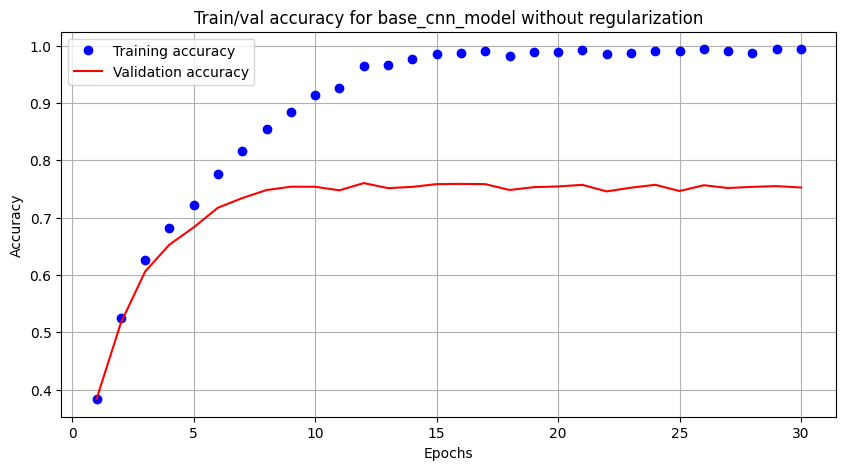

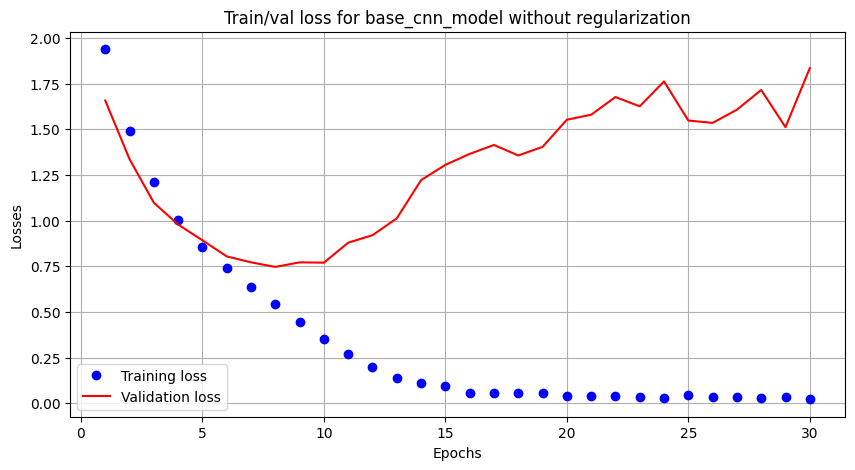

In [ ]:
epochs = np.arange(num_epochs)+1

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
# plt.subplot(211)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Train/val accuracy for base_cnn_model without regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('off')
plt.savefig('./IMGs/train_val_accuracy_without_regularization_2.png')
plt.show()

plt.figure(figsize=(10,5))
# plt.subplot(212)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Train/val loss for base_cnn_model without regularization')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.grid('off')
plt.savefig('./IMGs/train_val_loss_without_regularization_2.png')
plt.show()


In [41]:
from torchsummary import summary


model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          896
|    └─ReLU: 2-2                         [-1, 32, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          896
|    └─ReLU: 2-2                         [-1, 32, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]          

In [133]:
network = model
network.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [141]:
def draw_confusion_matrix(network,  cmap=plt.cm.Blues):

	label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

	predicted_labels = []
	true_labels = []
	with torch.no_grad():
		for data in val_dl:
			images, labels = data
			y_pred = network(images)
			_, predicted_class = torch.max(y_pred, 1)
			predicted_labels.extend(predicted_class.cpu().numpy().tolist())
			true_labels.extend([int(item) for item in  labels.cpu().numpy()] )
	

	confmat = confusion_matrix(true_labels, predicted_labels)

	fig, ax = plt.subplots(figsize=(8 ,8))
	im = ax.imshow(confmat, interpolation='nearest', cmap=cmap)
	ax.figure.colorbar(im, ax=ax)

	ax.set(xticks=np.arange(confmat.shape[1]),
           yticks=np.arange(confmat.shape[0]),
           xticklabels=label_name, yticklabels=label_name,
           title='Base Model Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
	
	plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

	fmt = 'd' 
	thresh = confmat.max() / 2.
	for i in range(confmat.shape[0]):
		for j in range(confmat.shape[1]):
			ax.text(j, i, format(confmat[i, j], fmt),
					ha="center", va="center",
					color="white" if confmat[i, j] > thresh else "black")
			
	fig.tight_layout()		 
	plt.xlabel('Predicted label') 
	plt.ylabel('True label')
	plt.savefig('./IMGs/Base_Class_Confusion_Matrix.png')
	plt.show()





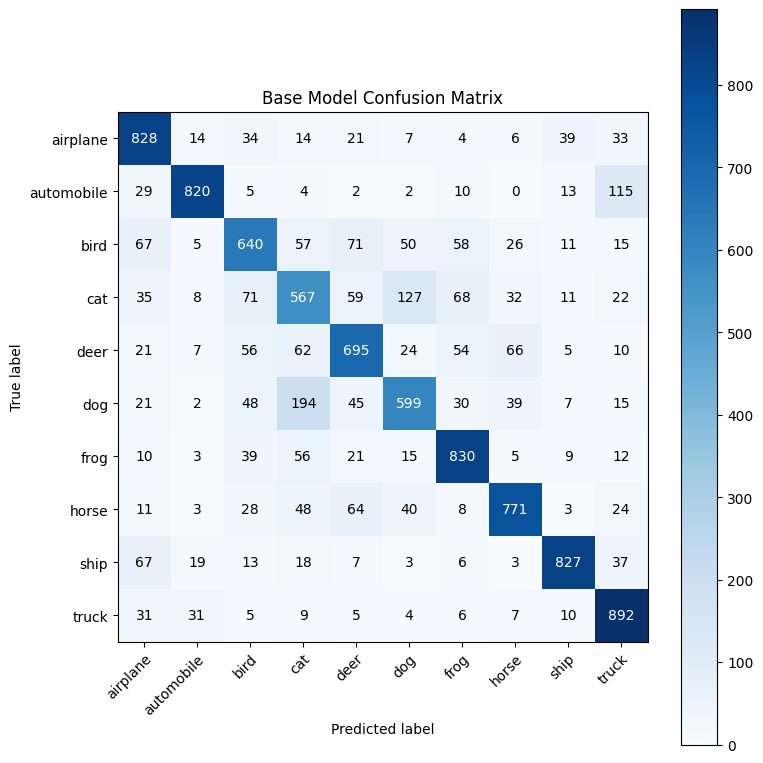

In [142]:
draw_confusion_matrix(model)